# Keras 3 Library
This tutorial re-implements the old [qml.qnn.KerasLayer](https://pennylane.ai/qml/demos/qnn_module_tf) demo using the Keras 3 based `KerasCircuitLayer` introduced here. 

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax" # This can be either JAX, tensorflow, or torch. (tensorflow by default)

In [2]:
import keras
from keras import ops
from keras import layers
from keras.models import Model
print(f"Keras backend: {keras.backend.backend()}")

import pennylane as qml
import jax.numpy as jnp
import numpy as  np
import matplotlib.pyplot as plt
import jax

from sklearn.datasets import make_moons

Keras backend: jax


## Get Dataset
Let us begin by choosing a simple dataset and problem to allow us to focus on how the hybrid model is constructed. Our objective is to classify points generated from scikit-learn’s binary-class make_moons() dataset:

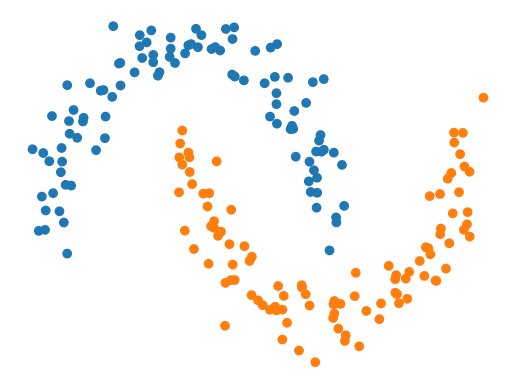

In [3]:
X, y = make_moons(n_samples=200, noise=0.1)
y_ = ops.unstack(y,1)
y_hot = ops.one_hot(y_,2)

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # colours for each class
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

## Define QNode
Our next step is to define the QNode that we want to interface with Keras. Any combination of device, operations and measurements that is valid in PennyLane can be used to compose the QNode. 
However, the QNode arguments must satisfy additional conditions including having an argument called inputs. All other arguments must be arrays or tensors and are treated as trainable weights in the model. We fix a two-qubit QNode using the default.qubit simulator and operations from the templates module.

In [4]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(weights,inputs):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

## Interfacing with Keras 3

With the QNode defined, we are ready to interface with Keras. This is achieved using the KerasLayer class of the qnn module, which converts the QNode to the elementary building block of Keras: a layer. We shall see in the following how the resultant layer can be combined with other well-known neural network layers to form a hybrid model.

We must first define the weight_shapes dictionary. Recall that all of the arguments of the QNode (except the one named inputs) are treated as trainable weights. For the QNode to be successfully converted to a layer in Keras, we need to provide the details of the shape of each trainable weight for them to be initialized. The weight_shapes dictionary maps from the argument names of the QNode to corresponding shapes:

In [5]:
from pennylane_keras_layer import KerasCircuitLayer

In [6]:
n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}

In our example, the weights argument of the QNode is trainable and has shape given by `(n_layers, n_qubits)`, which is passed to `BasicEntanglerLayers()`.

Now that `weight_shapes` is defined, it is easy to then convert the QNode:

In [7]:
# Create the layer
qlayer = KerasCircuitLayer(qnode, weight_shapes, output_dim=n_qubits,use_jax_python=True)

With this done, the QNode can now be treated just like any other Keras layer and we can proceed using the familiar Keras workflow. The `KerasCircuitLayer` also includes a `draw_qnode` method to **visualize the QNode** for convenient debugging and use. 

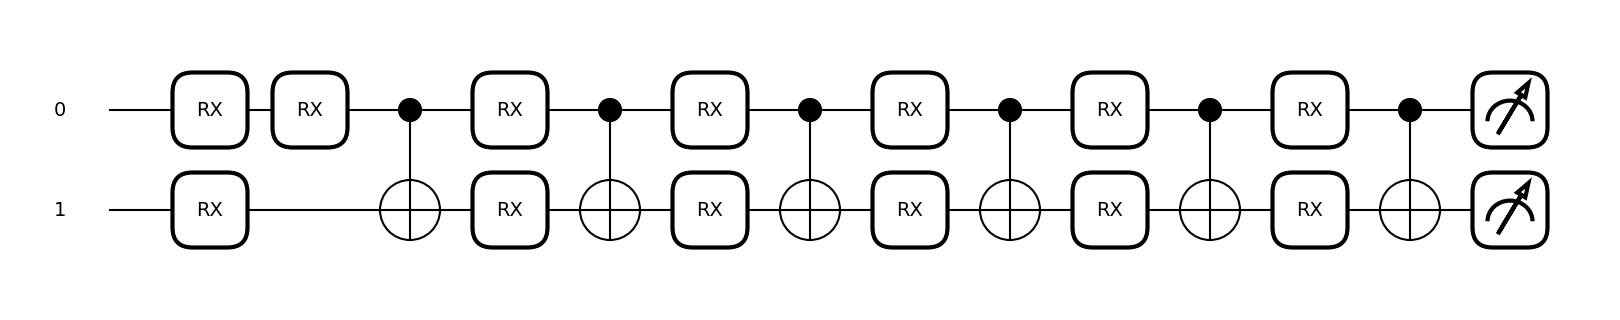

In [8]:
qlayer.draw_qnode([[2]],level="device")

## Creating the Hybrid Model
Let’s create a basic three-layered hybrid model consisting of:

1. a 2-neuron fully connected classical layer
2. our 2-qubit QNode converted into a layer
3. another 2-neuron fully connected classical layer
4. a softmax activation to convert to a probability vector

A diagram of the model can be seen in the figure below.
<center><img src="images/qnn_keras.png" alt="drawing" width="40%"/></center>

We can construct the model using the [Sequential API](https://keras.io/api/models/sequential/):

In [9]:
inputs = keras.layers.Input(shape=(2,))
clayer_1 = keras.layers.Dense(2)
clayer_2 = keras.layers.Dense(2, activation="softmax")
model = keras.models.Sequential([inputs,clayer_1, qlayer, clayer_2])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ keras_circuit_layer             │ (None, 2)              │            12 │
│ (KerasCircuitLayer)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24 (96.00 B)

 Trainable params: 24 (96.00 B)

 Non-trainable params: 0 (0.00 B)

### Training the model
We can now train our hybrid model on the classification dataset using the usual Keras approach. We’ll use the standard SGD optimizer and the mean absolute error loss function:'

In [10]:
opt = keras.optimizers.SGD(learning_rate=0.2)
model.compile(opt, loss="mae", metrics=["accuracy"])

Note that there are more advanced combinations of optimizer and loss function, but here we are focusing on the basics.

The model is now ready to be trained!

In [11]:
fitting = model.fit(X, y_hot, epochs=6, batch_size=5, validation_split=0.25, verbose=2)

Epoch 1/6
30/30 - 2s - 55ms/step - accuracy: 0.8333 - loss: 0.3878 - val_accuracy: 0.8600 - val_loss: 0.3051
Epoch 2/6
30/30 - 0s - 897us/step - accuracy: 0.8600 - loss: 0.2476 - val_accuracy: 0.8400 - val_loss: 0.2043
Epoch 3/6
30/30 - 0s - 904us/step - accuracy: 0.8733 - loss: 0.1919 - val_accuracy: 0.8600 - val_loss: 0.1783
Epoch 4/6
30/30 - 0s - 904us/step - accuracy: 0.8667 - loss: 0.1717 - val_accuracy: 0.8600 - val_loss: 0.1666
Epoch 5/6
30/30 - 0s - 870us/step - accuracy: 0.8867 - loss: 0.1595 - val_accuracy: 0.8600 - val_loss: 0.1574
Epoch 6/6
30/30 - 0s - 865us/step - accuracy: 0.8600 - loss: 0.1644 - val_accuracy: 0.8600 - val_loss: 0.1541


How did we do? The model looks to have successfully trained and the accuracy on both the training and validation datasets is reasonably high. In practice, we would aim to push the accuracy higher by thinking carefully about the model design and the choice of hyperparameters such as the learning rate.


## Creating non-sequential models
The model we created above was composed of a sequence of classical and quantum layers. This type of model is very common and is suitable in a lot of situations. However, in some cases we may want a greater degree of control over how the model is constructed, for example when we have multiple inputs and outputs or when we want to distribute the output of one layer into multiple subsequent layers.

Suppose we want to make a hybrid model consisting of:

1. a 4-neuron fully connected classical layer
2. a 2-qubit quantum layer connected to the first two neurons of the previous classical layer
3. a 2-qubit quantum layer connected to the second two neurons of the previous classical layer
4. a 2-neuron fully connected classical layer which takes a 4-dimensional input from the combination of the previous quantum layers
5. a softmax activation to convert to a probability vector

A diagram of the model can be seen in the figure below.
<center><img src="images/qnn2_keras.png" alt="drawing" width="40%"/></center>


This model can also be constructed using the [Functional API](https://keras.io/guides/functional_api/):

In [12]:
# re-define the layers
clayer_1 = keras.layers.Dense(4)
qlayer_1 = KerasCircuitLayer(qnode, weight_shapes, output_dim=n_qubits)
qlayer_2 = KerasCircuitLayer(qnode, weight_shapes, output_dim=n_qubits)
clayer_2 = keras.layers.Dense(2, activation="softmax")

# construct the model
inputs = keras.Input(shape=(2,))
x = clayer_1(inputs)
x_1, x_2 = ops.split(x, 2, axis=1)
x_1 = qlayer_1(x_1)
x_2 = qlayer_2(x_2)
x = ops.concatenate([x_1, x_2], axis=1)
outputs = clayer_2(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [13]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4)         │         12 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ split (Split)       │ [(None, 2),       │          0 │ dense_2[0][0]     │
│                     │ (None, 2)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_circuit_laye… │ (None, 2)         │         12 │ split[0][0]       │
│ (KerasCircuitLayer) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_circuit_laye… │ (None, 2)         │         12 │ split[0][1]       │
│ (KerasCircuitLayer) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4)         │          0 │ keras_circuit_la… │
│ (Concatenate)       │                   │            │ keras_circuit_la… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │         10 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 46 (184.00 B)

 Trainable params: 46 (184.00 B)

 Non-trainable params: 0 (0.00 B)

Train and check if it works

In [14]:
opt = keras.optimizers.SGD(learning_rate=0.2)
model.compile(opt, loss="mae", metrics=["accuracy"])

fitting = model.fit(X, y_hot, epochs=5, batch_size=5, validation_split=0.25, verbose=2)

Epoch 1/5
30/30 - 2s - 58ms/step - accuracy: 0.5133 - loss: 0.4774 - val_accuracy: 0.8200 - val_loss: 0.3137
Epoch 2/5
30/30 - 0s - 2ms/step - accuracy: 0.8200 - loss: 0.2499 - val_accuracy: 0.8200 - val_loss: 0.1932
Epoch 3/5
30/30 - 0s - 2ms/step - accuracy: 0.8400 - loss: 0.1908 - val_accuracy: 0.8400 - val_loss: 0.1745
Epoch 4/5
30/30 - 0s - 2ms/step - accuracy: 0.8467 - loss: 0.1727 - val_accuracy: 0.8800 - val_loss: 0.1616
Epoch 5/5
30/30 - 0s - 2ms/step - accuracy: 0.8467 - loss: 0.1623 - val_accuracy: 0.8400 - val_loss: 0.1579


## Model Saving and Loading

### Saving Models 
Models can be saved normally

In [15]:
model.save("test.keras")

### Loading Models 
Loading a model is tricky. Since a `QNode` can't be serialized yet, the model saves the weights but not the circuit structure itself. Hence, when the model is loaded it delays the circuit and interface parts of the `build` process till the `set_qnode` function is called to associate a `QNode` to it.

In [16]:
model_new = keras.models.load_model("test.keras")

Delaying circuit creation till QNode is set using the 'set_qnode' method
Delaying circuit creation till QNode is set using the 'set_qnode' method


Trying to run inference at this stage will through an error.

In [17]:
model_new(X[:2])

TypeError: Exception encountered when calling KerasCircuitLayer.call().

[1m'NoneType' object is not callable[0m

Arguments received by KerasCircuitLayer.call():
  • inputs=jnp.ndarray(shape=(2, 2), dtype=float32)

Calling the `set_qnode` function also calls `build` method and fully initializes the layer

In [18]:
model_new.layers[2].set_qnode(qnode)
model_new.layers[3].set_qnode(qnode)

Verifying QNode compatibility
Updating QNode
Verifying QNode compatibility
Updating QNode


We can then do inference or more training with the model as normal

In [19]:
model_new(X[:2])

Array([[0.9952228 , 0.00477717],
       [0.9831518 , 0.01684821]], dtype=float32)